# Kings County Holdout Data


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from datetime import datetime
import pickle


In [61]:
test_df = pd.read_csv('/Users/anishamalhotra/Documents/Flatiron/Phase2Project/kc_house_data_test_features.csv')
test_df = test_df.drop('Unnamed: 0', axis=1)
pd.set_option('display.max_columns', None)


In [62]:
infile = open("model.pickle",'rb')
model = pickle.load(infile)
infile.close()

In [96]:
print(model.intercept_)
print(len(model.coef_))

90550199.86489864
80


In [64]:
infile = open("br_median.pickle",'rb')
br_median = pickle.load(infile)
infile.close()

In [65]:
br_median

2.25

# Data Cleaning

In [66]:
test_df.isna().sum() #no missing data for test_df

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [67]:
test_df['bedrooms'].value_counts() #no abnormalities here

3     1896
4     1415
2      556
5      363
6       43
1       38
7        5
8        2
0        2
10       1
9        1
Name: bedrooms, dtype: int64

Imputing bathroom values of 0 or 0.5 to the median bathroom value of the data for each data set. 

In [68]:
test_df['bathrooms'] = test_df['bathrooms'].replace(to_replace=[0,.05], value=br_median)

Scaling down any values in sqft_living greater than 5000.

In [69]:
test_df.loc[test_df["sqft_living"]>5000, "sqft_living"] = test_df['sqft_living']*.65

Text(0.5, 1.0, 'Test Correlation Heat Map')

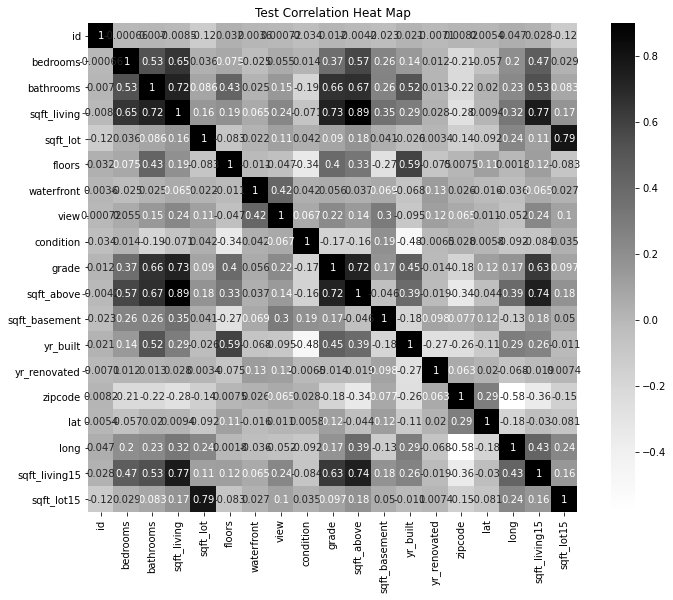

In [70]:
corrmat_test = test_df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat_test, vmax=0.9, square=True, cmap = 'Greys', annot=True);
ax.set_title('Test Correlation Heat Map')

# Feature Engineering

In [71]:
test_df['years_old'] = 2021 - test_df['yr_built']

In [72]:
test_df['sqft_yard'] = test_df['sqft_lot'] - (test_df['sqft_living']/test_df['floors'])

#### Importing Crime Data

In [73]:
# imported new csv file to get population of each zip code
crime = pd.read_csv('/Users/anishamalhotra/Documents/Flatiron/Phase2Project/crimes.csv')
#dropped all irrelevent columns
crime = crime.drop(['case_number','incident_datetime','FCR','address_1','city','state','created_at','updated_at','hour_of_day','day_of_week','Incident Block Location'], axis=1)
crime = crime.rename(columns={'zip':'zipcode'})

In [74]:
#selected columns from each df before merge
crime_count_per_zip = crime.groupby('zipcode').count()
crime_count_per_zip = crime_count_per_zip.reset_index()
crime_count_per_zip = crime_count_per_zip.drop(207, axis=0)


In [75]:
def crime_level(number):
    if number<=250: 
        return ('low')
    elif number>600:
        return('high')
    elif number==np.nan:
        return('low')
    else:
        return ('medium') #between 250 and 600
crime_count_per_zip['crime_rate'] = crime_count_per_zip['incident_type'].map(crime_level)

In [76]:
crime_count_per_zip['zipcode'] = crime_count_per_zip['zipcode'].astype('int')

In [77]:
test_df = test_df.merge(crime_count_per_zip, how='left',on='zipcode')

In [78]:
test_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,years_old,sqft_yard,incident_type,crime_rate
0,1974300020,20140827T000000,4,2.50,2270.0,11500,1.0,0,0,3,8,1540,730,1967,0,98034,47.7089,-122.241,2020,10918,54,9230.0,19.0,low
1,1974300020,20150218T000000,4,2.50,2270.0,11500,1.0,0,0,3,8,1540,730,1967,0,98034,47.7089,-122.241,2020,10918,54,9230.0,19.0,low
2,3630020380,20141107T000000,3,2.50,1470.0,1779,2.0,0,0,3,8,1160,310,2005,0,98029,47.5472,-121.998,1470,1576,16,1044.0,71.0,low
3,1771000290,20141203T000000,3,1.75,1280.0,16200,1.0,0,0,3,8,1030,250,1976,0,98077,47.7427,-122.071,1160,10565,45,14920.0,275.0,medium
4,5126310470,20150115T000000,4,2.75,2830.0,8126,2.0,0,0,3,8,2830,0,2005,0,98059,47.4863,-122.140,2830,7916,16,6711.0,574.0,medium


In [101]:
cols = ['bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']
test_dummy_df = pd.get_dummies(test_df[cols], columns=['zipcode','waterfront','crime_rate'])
test_dummy_df.head()

,bedrooms,bathrooms,sqft_living,grade,years_old,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_0,waterfront_1,crime_rate_high,crime_rate_low,crime_rate_medium
0,4,2.50,2270.0,8,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,4,2.50,2270.0,8,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,3,2.50,1470.0,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,3,1.75,1280.0,8,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,4,2.75,2830.0,8,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


# Run the Model

In [97]:
final_answers = model.predict(test_dummy_df)
final_answers_exp = np.exp(final_answers)

In [98]:
final_answers_exp = pd.DataFrame(final_answers_exp)

In [100]:
final_answers_exp.describe()

,0
count,4.322000e+03
mean,5.540107e+05
std,3.288507e+05
min,1.461361e+05
25%,3.507815e+05
50%,4.764209e+05
75%,6.367990e+05
max,3.227810e+06


## Export Predictions

In [90]:
# final_answers_exp.to_csv('housing_preds_anisha_malhotra.csv')